# Using petsc4py for sparse linear systems

[PETSc](https://www.mcs.anl.gov/petsc/) is a widely used software for the solution of linear and nonlinear systems of equations arising from PDE discretisations. It has powerful data structures to scale computations from simple workstations to petascale clusters. In this notebook we want to demonstrate some of the features of PETsc for the solution of sparse linear systems of equations. While Scipy is well suited for smaller and medium sized problems, PETSc is ideal if software is meant to eventually scale across clusters of computers.

## Creating a sparse matrix in PETSc

The main object in PETSc for creating sparse matrices is  the MAT object. Typically, we create a sparse matrix in three steps.

* Specify the layout of the matrix
* Assign the matrix elements
* Assemble the matrix

PETSc by default uses the CSR matrix format and distributes rows across different compute nodes. In this example we do not use the parallel features of PETSc and refer to the documentation for details.

Let's get started and specify a matrix of dimension 1000 x 1000. We want to have a tridiagonal matrix, so will have two entries in the first and last row, and three entries in each other row. PETSc can dynamically grow sizes needed to store matrix entries. But this is inefficient and it is useful to preallocate the storage size.

In [145]:
from petsc4py import PETSc
import numpy as np

n = 1000

nnz = 3 * np.ones(1000, dtype=np.int32)
nnz[0] = nnz[-1] = 2

A = PETSc.Mat()
A.createAIJ([n, n], nnz=nnz)

We can now fill the matrix elements.

In [146]:
# First set the first row
A.setValue(0, 0, 2)
A.setValue(0, 1, -1)
# Now we fill the last row
A.setValue(999, 998, -1)
A.setValue(999, 999, 2)

# And now everything else
for index in range(1, n - 1):
    A.setValue(index, index - 1, -1)
    A.setValue(index, index, 2)
    A.setValue(index, index + 1, -1)    

Finally, we can assemble the matrix. This lets PETsc create all necessary internal data structures.

In [147]:
A.assemble()

We now have a PETSc matrix to our disposal. Let's try some commands.

Get the size of the matrix.

In [148]:
A.size

(1000, 1000)

Get the local size. This is the storage in the current process and only relevant for parallel operation.

In [149]:
A.local_size

(1000, 1000)

Check if the matrix is symmetric.

In [150]:
A.isSymmetric()

True

There are lots of convenience functions to access matrix elements. For example, to get the diagonal values we can do the following.

In [151]:
diagonals = A.getDiagonal().array
print(diagonals.shape)

(1000,)


Get memory information about the matrix.

In [152]:
A.getInfo()

{'block_size': 1.0,
 'nz_allocated': 2998.0,
 'nz_used': 2998.0,
 'nz_unneeded': 0.0,
 'memory': 59212.0,
 'assemblies': 1.0,
 'mallocs': 0.0,
 'fill_ratio_given': 0.0,
 'fill_ratio_needed': 0.0,
 'factor_mallocs': 0.0}

Return the data structurs associated with the CSR matrix.

In [153]:
indexptr, indices, data = A.getValuesCSR()

## Solving a linear system with the matrix.

We now want to solve a linear system of equations with this matrix. The basic solver object is `ksp`.

In [154]:
ksp = PETSc.KSP().create()

We need to let `ksp` know about the operator.

In [155]:
ksp.setOperators(A)

We need to define our right-hand side. It is important to choose vectors that are compatible with the data distribution of $A$. Let $y=Ax$. Then to get the data distribution for $A$ we need `A.createVecLeft`. To get the data distribution for $x$ we need to use `A.createVecRight`.

In [156]:
b = A.createVecLeft()
b.array[:] = 1

The following initialised the full solver and solves the problem. As iterative solver we choose `BicgStab` (denoted by the parameter `bcgs`). This is an iterative solver for nonsymmetric systems of equations that requires only a short recurrence and therefore, in contrast to GMRES, does not need to store the whole Krylov subspace basis. The disadvantage is that it does not guarantee that the residual is minimized in each step.
As preconditioner we set `none`, which disables preconditioning for now. We also save the convergence history so that we can plot it afterwards.


In [157]:
x = A.createVecRight()

ksp = PETSc.KSP().create()
ksp.setOperators(A)
ksp.setType('bcgs')
ksp.setConvergenceHistory()
ksp.getPC().setType('none')
ksp.solve(b, x)

We can now plot the residual curve.

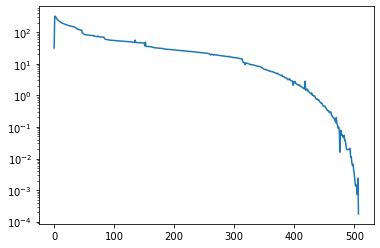

In [158]:
%matplotlib inline
from matplotlib import pyplot as plt

residuals = ksp.getConvergenceHistory()
plt.semilogy(residuals)

PETSc knows a huge number of preconditioners. For example, the following uses SOR as preconditioner.

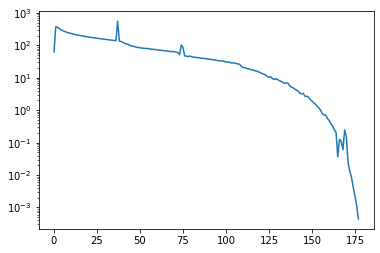

In [159]:
x = A.createVecRight()

ksp = PETSc.KSP().create()
ksp.setOperators(A)
ksp.setType('bcgs')
ksp.setConvergenceHistory()
ksp.getPC().setType('sor')
ksp.solve(b, x)
plt.semilogy(ksp.getConvergenceHistory())

If we want to use a direct solver with PETSc we neeed to specify the direct solver as preconditioner and tell PETSc to only evaluate the precondtiioner. This seems a bit strange but allows iterative and direct solvers to have the same interface.

In [160]:
x = A.createVecRight()

ksp = PETSc.KSP().create()
ksp.setOperators(A)
ksp.setType('preonly')
ksp.setConvergenceHistory()
ksp.getPC().setType('lu')
ksp.solve(b, x)

residual = A * x - b
print(f"The relative residual is: {residual.norm() / b.norm()}.")

The relative residual is: 8.358396715688236e-12.


## Conclusions

PETSc is an amazing library. It makes it simple to build solvers that scale from small workstations to huge clusters. With petsc4py most PETSc functions are available from Python. The main problem with petsc4py is that while PETSc has great documentation, petsc4py is mostly undocumented. The function names in petsc4py are similar to those in PETSc. So using the PETSc documentation often helps. If this is not sufficient then the best approach is to directly look into the petscpy source code to see how information is transferred on to PETSc.